<a href="https://colab.research.google.com/github/ersjunior/3DTS-MachineLearningOps/blob/main/Aula_3/Plataformas_Azure_Treino_Fora_Azure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup



<font color="red">Caso apareça um botão como esse durante o setup, deve ser necessário reiniciar o "Runtime"</font>


Pode ser feito clicando no botão ou pelo menu do Colab.

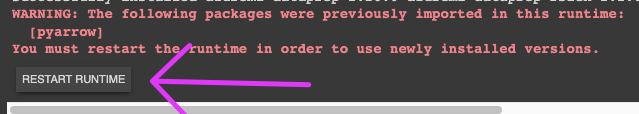

In [1]:
!git clone https://github.com/elthonf/azure-ml.git

Cloning into 'azure-ml'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 274 (delta 20), reused 10 (delta 4), pack-reused 239
Receiving objects: 100% (274/274), 11.99 MiB | 20.53 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [2]:
!pip install joblib~=1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.3.2
    Uninstalling joblib-1.3.2:
      Successfully uninstalled joblib-1.3.2


In [3]:
!pip install scikit-learn~=1.1.0
#!pip install scikit-learn~=1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [4]:
!pip install azureml-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.4/192.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.0/933.0 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#!pip install azureml-dataprep
#!pip install azureml-dataset-runtime

In [5]:
!mkdir modelo
!mkdir modelo/ambiente
!mkdir dadostreino
!pip list > modelo/ambiente/bibliotecas.txt
!pip freeze > modelo/ambiente/requirements.txt
!python --version > modelo/ambiente/python_version.txt

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, classification_report
import sys, math, random, json, sklearn, joblib, uuid, os
from azureml.core import Experiment, Workspace, Dataset, Model

In [7]:
sklearn.__version__

'1.1.3'

Funções auxiliares

In [8]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [9]:
def describe(df):
    return pd.concat([df.describe(include="all", percentiles=[.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9]).T,
                      df.dtypes.rename('dtypes'),
                      #df.mad().rename('mad'),
                      #df.skew().rename('skew'),
                      #df.kurt().rename('kurt'),
                      df.nunique().rename('nunique'),
                     ], axis=1)
def describe_cols(df, df_summary=None):
    if df_summary is None:
        df_summary = describe(df)
    ret = {}
    for i, row in df_summary.iterrows():
        if row["nunique"] <= 100:
            ret[i] = {"classes" : json.loads( df.groupby([i]).size().to_json() ) }
        elif np.issubdtype(row["dtypes"], np.number):
            _h = np.histogram(df[i])
            ret[i] = {"hist": list(_h[0]),
                      "bin_edges": list(_h[1])}
        else:
            ret[i] = {}
    return ret

# Conexão com ML Studio

In [10]:
#Trocar os códigos abaixo pelos da sua instância!
subscription_id = 'b8992cb7-2590-4713-9288-bfd63e745643'
resource_group = '3DTSR'
workspace_name = 'wsmachinelearning'

workspace = Workspace(subscription_id, resource_group, workspace_name)

Performing interactive authentication. Please follow the instructions on the terminal.


Interactive authentication successfully completed.


# Carga de dados
Inclui métricas dos dados / metadados

In [11]:
mydf = pd.read_csv('azure-ml/datasets/statistical/BaseDefault01.csv')
mydf.head()

,nome,renda,idade,etnia,sexo,casapropria,outrasrendas,estadocivil,escolaridade,default
0,"Simon, Rodriguez",4472.190323,42.036031,0,0,1,0,0,3,0
1,"Daniel, Castro",4592.774312,48.230662,1,0,1,0,1,2,0
2,"Myhue, Lin",2486.538807,56.881709,0,1,0,0,0,0,1
3,"Destiny, Richardson-Pacheco",2852.340117,51.684021,1,1,0,0,0,2,1
4,"Brittany, Cohen-Wilson",4703.782812,50.729078,1,1,1,0,1,2,0


In [ ]:
#dataset = Dataset.get_by_name(workspace, name='Risco-De-Credito')
#df = dataset.to_pandas_dataframe()
#df.head()

In [12]:
mydf.to_csv("./dadostreino/original_data.csv")

In [13]:
mydf_metadata = describe(mydf)
#mydf_metadata.to_json("./dadostreino/metadata.json", indent=4, orient='index')
mydf_metadata.to_markdown("./dadostreino/metadata.md")
mydf_metadata.to_csv("./dadostreino/metadata.csv")
mydf_metadata

,count,unique,top,freq,mean,std,min,10%,20%,25%,...,40%,50%,60%,70%,75%,80%,90%,max,dtypes,nunique
nome,100000,96546,"Andrew, Nguyen",10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,96546
renda,100000.0,NaN,NaN,NaN,3549.511518,804.766033,1008.14707,2433.267828,2847.749606,2999.406891,...,3345.294497,3553.223201,3764.81879,4003.569725,4143.017046,4292.027575,4641.554209,5727.149211,float64,100000
idade,100000.0,NaN,NaN,NaN,38.819483,11.330192,18.00046,22.506054,28.118952,30.203688,...,35.500646,38.829486,42.125037,45.451067,47.23245,49.19211,54.128594,81.859679,float64,100000
etnia,100000.0,NaN,NaN,NaN,0.4766,0.499455,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,int64,2
sexo,100000.0,NaN,NaN,NaN,0.47714,0.49948,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,int64,2
casapropria,100000.0,NaN,NaN,NaN,0.4744,0.499347,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,int64,2
outrasrendas,100000.0,NaN,NaN,NaN,0.23312,0.42282,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,int64,2
estadocivil,100000.0,NaN,NaN,NaN,0.58106,0.493388,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,int64,2
escolaridade,100000.0,NaN,NaN,NaN,1.72235,0.87798,0.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,int64,4
default,100000.0,NaN,NaN,NaN,0.45068,0.497564,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,int64,2


In [14]:
# gera arquivo de quantidade por classes
mycounts = describe_cols(mydf, mydf_metadata)

with open('dadostreino/classes.json', 'w', encoding='utf-8') as f:
    json.dump(mycounts, f, ensure_ascii=False, indent=4, cls=NpEncoder)

In [15]:
display(mycounts)

{'nome': {},
 'renda': {'hist': [92,
   1998,
   7710,
   11636,
   19607,
   22277,
   17291,
   12827,
   6175,
   387],
  'bin_edges': [1008.1470703741144,
   1480.0472844645553,
   1951.9474985549964,
   2423.8477126454372,
   2895.7479267358785,
   3367.6481408263194,
   3839.54835491676,
   4311.4485690072015,
   4783.348783097643,
   5255.248997188083,
   5727.1492112785245]},
 'idade': {'hist': [12845,
   13666,
   18505,
   19278,
   17438,
   11678,
   5602,
   946,
   41,
   1],
  'bin_edges': [18.00046033691615,
   24.38638225146161,
   30.772304166007075,
   37.15822608055254,
   43.544147995098,
   49.930069909643464,
   56.31599182418893,
   62.70191373873439,
   69.08783565327985,
   75.47375756782532,
   81.85967948237078]},
 'etnia': {'classes': {'0': 52340, '1': 47660}},
 'sexo': {'classes': {'0': 52286, '1': 47714}},
 'casapropria': {'classes': {'0': 52560, '1': 47440}},
 'outrasrendas': {'classes': {'0': 76688, '1': 23312}},
 'estadocivil': {'classes': {'0': 41894,

# Treinamento

Identifica no dataset as variáveis independentes e a variavel alvo

In [16]:
targetcol = 'default'
y = mydf[targetcol]

Cria experimento

In [17]:
experiment = Experiment(workspace=workspace, name="Experimento_MLStudio")

## Treina modelo 01 (Classificador)

Cria uma execução para o experimento

In [18]:
myrunid = str(uuid.uuid1())
run = experiment.start_logging(run_id=myrunid,
                               display_name=f"My Run {myrunid} feito em aula",
                               outputs="modelo",
                               snapshot_directory="dadostreino")
run.log("Tipo", "Classificador")

In [19]:
independentcols = ['renda', 'idade', 'etnia', 'sexo', 'casapropria', 'outrasrendas', 'estadocivil', 'escolaridade']
X = mydf[independentcols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
clf = rfc(n_estimators=10)
clf.fit(X=X_train[independentcols], y=y_train)
clf.independentcols = independentcols

Avaliações e Logs

In [20]:
clf_acuracia = clf.score(X=X_test[independentcols], y=y_test)
print("Modelo 01 (classificador), criado com acurácia de: [{0}]".format(clf_acuracia))
run.log("acuracia", clf_acuracia)

Modelo 01 (classificador), criado com acurácia de: [0.85665]


In [21]:
#Demais logs (não serão comparados)
run.log("python", sys.version)
run.log("Versao sklearn", sklearn.__version__)
run.log("criterion", clf.criterion)
run.log("n_estimators", clf.n_estimators)
run.log("min_samples_leaf", clf.min_samples_leaf)
run.log("max_depth",  str(clf.max_depth))
run.log_list("Inputs", independentcols)

'Matriz de confusão do modelo:'

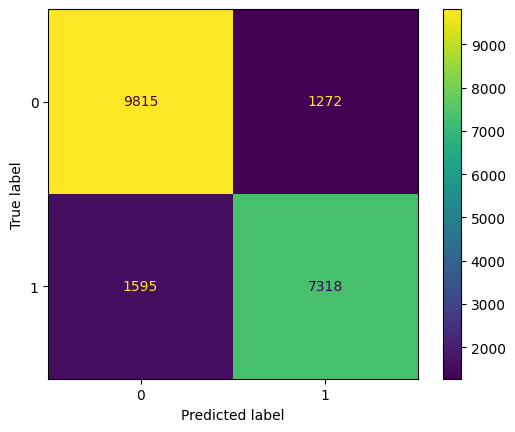

In [22]:
#Exibe Matriz de confusão e grava em arquivo
display(f"Matriz de confusão do modelo:")
ConfusionMatrixDisplay.from_estimator(clf, X_test[independentcols], y_test).figure_.savefig('modelo/confusion_matrix.png')

In [23]:
#Exibe Classification Report e grava em arquivo
c_report = classification_report(y_test, clf.predict(X_test[independentcols]))
print(f"Classification Report:\n{c_report}")
with open("modelo/classification_report.txt", "w") as text_file:
    text_file.write(c_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     11087
           1       0.85      0.82      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.85      0.85     20000
weighted avg       0.86      0.86      0.86     20000



Exporta o modelo

Dica: Após a exportação, é possível consultar o modelo e demais artefatos pelo explorador de arquivos, ou com a instrução:

```
!ls -l modelo
```

In [24]:
model_name = "modelo_bin.pkl"
filename = "modelo/" + model_name
joblib.dump(value=clf, filename=filename)

['modelo/modelo_bin.pkl']

Finaliza o experimento
Obs.:pode demorar alguns segundos/minutos para os arquivos da pasta "modelo" aparecerem no Azure ML Studio.

In [25]:
run.complete()
run.wait_for_completion()
os.remove("./modelo/modelo_bin.pkl")
os.remove("./modelo/confusion_matrix.png")
os.remove("./modelo/classification_report.txt")

# Atividade 1 : Análise na Azure

Crie n modelos em experimentos para nosso problema de risco de crédito, e envie para a Azure. Em seguida, compare os resultados dentro da plataforma Azure.  

Cada experimento deve ter seus parâmetros alterados conforme vetores.  
Observe que o nomes dos parâmetros são respectivamente n_estimators, max_depth e min_samples_leaf.

|n_estimators|max_depth|min_samples_leaf|
|---|---|---|
|1|1|10|
|2|2|5|
|3|3|1|
|5|None|
|10|
|20|
|30|
|100|

Obs.:  
n = 8 $\times$ 4 $\times$ 3

In [26]:
experiment = Experiment(workspace=workspace, name="Experimento_RiscoCredito")

In [27]:
n_estimators = [1, 2, 3, 5, 10, 20, 30, 100]
max_depth = [1, 2, 3, None]
min_samples_leaf = [10, 5, 1]

Modelo - (classificador), criado com acurácia de: [0.66875]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69     11087
           1       0.62      0.66      0.64      8913

    accuracy                           0.67     20000
   macro avg       0.67      0.67      0.67     20000
weighted avg       0.67      0.67      0.67     20000

Modelo - (classificador), criado com acurácia de: [0.74035]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75     11087
           1       0.68      0.80      0.73      8913

    accuracy                           0.74     20000
   macro avg       0.74      0.75      0.74     20000
weighted avg       0.75      0.74      0.74     20000

Modelo - (classificador), criado com acurácia de: [0.74035]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75     11087
           1       0.68      0.80      0.73      8913

    accuracy                           0.74     20000
   macro avg       0.74      0.75      0.74     20000
weighted avg       0.75      0.74      0.74     20000

Modelo - (classificador), criado com acurácia de: [0.66985]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69     11087
           1       0.62      0.66      0.64      8913

    accuracy                           0.67     20000
   macro avg       0.67      0.67      0.67     20000
weighted avg       0.67      0.67      0.67     20000

Modelo - (classificador), criado com acurácia de: [0.76775]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.65      0.76     11087
           1       0.68      0.91      0.78      8913

    accuracy                           0.77     20000
   macro avg       0.79      0.78      0.77     20000
weighted avg       0.80      0.77      0.77     20000

Modelo - (classificador), criado com acurácia de: [0.7697]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.66      0.76     11087
           1       0.68      0.91      0.78      8913

    accuracy                           0.77     20000
   macro avg       0.79      0.78      0.77     20000
weighted avg       0.80      0.77      0.77     20000

Modelo - (classificador), criado com acurácia de: [0.83175]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85     11087
           1       0.83      0.79      0.81      8913

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000

Modelo - (classificador), criado com acurácia de: [0.74645]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79     11087
           1       0.79      0.58      0.67      8913

    accuracy                           0.75     20000
   macro avg       0.76      0.73      0.73     20000
weighted avg       0.75      0.75      0.74     20000

Modelo - (classificador), criado com acurácia de: [0.7417]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78     11087
           1       0.75      0.62      0.68      8913

    accuracy                           0.74     20000
   macro avg       0.74      0.73      0.73     20000
weighted avg       0.74      0.74      0.74     20000

Modelo - (classificador), criado com acurácia de: [0.85455]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     11087
           1       0.84      0.83      0.84      8913

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.8437]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     11087
           1       0.83      0.82      0.82      8913

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000

Modelo - (classificador), criado com acurácia de: [0.83025]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     11087
           1       0.81      0.82      0.81      8913

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000

Modelo - (classificador), criado com acurácia de: [0.73605]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79     11087
           1       0.81      0.53      0.64      8913

    accuracy                           0.74     20000
   macro avg       0.76      0.72      0.72     20000
weighted avg       0.75      0.74      0.72     20000

Modelo - (classificador), criado com acurácia de: [0.7422]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77     11087
           1       0.72      0.69      0.70      8913

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000

Modelo - (classificador), criado com acurácia de: [0.73605]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79     11087
           1       0.81      0.53      0.64      8913

    accuracy                           0.74     20000
   macro avg       0.76      0.72      0.72     20000
weighted avg       0.75      0.74      0.72     20000

Modelo - (classificador), criado com acurácia de: [0.7643]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80     11087
           1       0.76      0.69      0.72      8913

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Modelo - (classificador), criado com acurácia de: [0.8166]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85     11087
           1       0.87      0.70      0.77      8913

    accuracy                           0.82     20000
   macro avg       0.83      0.80      0.81     20000
weighted avg       0.82      0.82      0.81     20000

Modelo - (classificador), criado com acurácia de: [0.84065]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     11087
           1       0.80      0.85      0.83      8913

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000

Modelo - (classificador), criado com acurácia de: [0.83695]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     11087
           1       0.85      0.78      0.81      8913

    accuracy                           0.84     20000
   macro avg       0.84      0.83      0.83     20000
weighted avg       0.84      0.84      0.84     20000

Modelo - (classificador), criado com acurácia de: [0.8526]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     11087
           1       0.85      0.81      0.83      8913

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.8604]


'Matriz de confusão do modelo:'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88     11087
           1       0.86      0.83      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.8646]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11087
           1       0.85      0.85      0.85      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.86175]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     11087
           1       0.85      0.84      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.82765]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     11087
           1       0.87      0.72      0.79      8913

    accuracy                           0.83     20000
   macro avg       0.84      0.82      0.82     20000
weighted avg       0.83      0.83      0.83     20000

Modelo - (classificador), criado com acurácia de: [0.7626]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81     11087
           1       0.86      0.56      0.68      8913

    accuracy                           0.76     20000
   macro avg       0.79      0.74      0.74     20000
weighted avg       0.78      0.76      0.75     20000

Modelo - (classificador), criado com acurácia de: [0.66985]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69     11087
           1       0.62      0.66      0.64      8913

    accuracy                           0.67     20000
   macro avg       0.67      0.67      0.67     20000
weighted avg       0.67      0.67      0.67     20000

Modelo - (classificador), criado com acurácia de: [0.7348]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79     11087
           1       0.81      0.52      0.64      8913

    accuracy                           0.73     20000
   macro avg       0.76      0.71      0.71     20000
weighted avg       0.75      0.73      0.72     20000

Modelo - (classificador), criado com acurácia de: [0.8185]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     11087
           1       0.82      0.77      0.79      8913

    accuracy                           0.82     20000
   macro avg       0.82      0.81      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Modelo - (classificador), criado com acurácia de: [0.79065]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82     11087
           1       0.83      0.67      0.74      8913

    accuracy                           0.79     20000
   macro avg       0.80      0.78      0.78     20000
weighted avg       0.80      0.79      0.79     20000

Modelo - (classificador), criado com acurácia de: [0.84025]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.86     11087
           1       0.88      0.74      0.81      8913

    accuracy                           0.84     20000
   macro avg       0.85      0.83      0.84     20000
weighted avg       0.84      0.84      0.84     20000

Modelo - (classificador), criado com acurácia de: [0.8247]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     11087
           1       0.84      0.75      0.79      8913

    accuracy                           0.82     20000
   macro avg       0.83      0.82      0.82     20000
weighted avg       0.83      0.82      0.82     20000

Modelo - (classificador), criado com acurácia de: [0.82365]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85     11087
           1       0.83      0.76      0.79      8913

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Modelo - (classificador), criado com acurácia de: [0.84895]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     11087
           1       0.82      0.85      0.83      8913

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.87125]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11087
           1       0.86      0.85      0.86      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.8659]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11087
           1       0.85      0.85      0.85      8913

    accuracy                           0.87     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.84585]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     11087
           1       0.82      0.83      0.83      8913

    accuracy                           0.85     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.85      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.7589]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.95      0.81     11087
           1       0.89      0.52      0.66      8913

    accuracy                           0.76     20000
   macro avg       0.80      0.74      0.74     20000
weighted avg       0.79      0.76      0.74     20000

Modelo - (classificador), criado com acurácia de: [0.74035]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75     11087
           1       0.68      0.80      0.73      8913

    accuracy                           0.74     20000
   macro avg       0.74      0.75      0.74     20000
weighted avg       0.75      0.74      0.74     20000

Modelo - (classificador), criado com acurácia de: [0.74035]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75     11087
           1       0.68      0.80      0.73      8913

    accuracy                           0.74     20000
   macro avg       0.74      0.75      0.74     20000
weighted avg       0.75      0.74      0.74     20000

Modelo - (classificador), criado com acurácia de: [0.8415]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     11087
           1       0.80      0.87      0.83      8913

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000

Modelo - (classificador), criado com acurácia de: [0.8483]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     11087
           1       0.82      0.84      0.83      8913

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.76705]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.77     11087
           1       0.70      0.82      0.76      8913

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.78      0.77      0.77     20000

Modelo - (classificador), criado com acurácia de: [0.8377]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     11087
           1       0.86      0.76      0.81      8913

    accuracy                           0.84     20000
   macro avg       0.84      0.83      0.83     20000
weighted avg       0.84      0.84      0.84     20000

Modelo - (classificador), criado com acurácia de: [0.84565]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87     11087
           1       0.86      0.78      0.82      8913

    accuracy                           0.85     20000
   macro avg       0.85      0.84      0.84     20000
weighted avg       0.85      0.85      0.84     20000

Modelo - (classificador), criado com acurácia de: [0.8573]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     11087
           1       0.84      0.83      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.87395]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11087
           1       0.86      0.86      0.86      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.87005]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11087
           1       0.86      0.85      0.85      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.8498]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     11087
           1       0.83      0.83      0.83      8913

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.7973]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84     11087
           1       0.90      0.61      0.73      8913

    accuracy                           0.80     20000
   macro avg       0.83      0.78      0.78     20000
weighted avg       0.82      0.80      0.79     20000

Modelo - (classificador), criado com acurácia de: [0.78395]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82     11087
           1       0.85      0.62      0.72      8913

    accuracy                           0.78     20000
   macro avg       0.80      0.77      0.77     20000
weighted avg       0.80      0.78      0.78     20000

Modelo - (classificador), criado com acurácia de: [0.79975]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     11087
           1       0.79      0.74      0.77      8913

    accuracy                           0.80     20000
   macro avg       0.80      0.79      0.80     20000
weighted avg       0.80      0.80      0.80     20000

Modelo - (classificador), criado com acurácia de: [0.8535]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     11087
           1       0.88      0.78      0.83      8913

    accuracy                           0.85     20000
   macro avg       0.86      0.85      0.85     20000
weighted avg       0.86      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.84945]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     11087
           1       0.90      0.74      0.81      8913

    accuracy                           0.85     20000
   macro avg       0.86      0.84      0.84     20000
weighted avg       0.86      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.8367]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     11087
           1       0.83      0.80      0.81      8913

    accuracy                           0.84     20000
   macro avg       0.84      0.83      0.83     20000
weighted avg       0.84      0.84      0.84     20000

Modelo - (classificador), criado com acurácia de: [0.8603]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88     11087
           1       0.86      0.82      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.85575]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     11087
           1       0.85      0.82      0.83      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.85      0.85     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.84825]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     11087
           1       0.81      0.86      0.83      8913

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.8735]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11087
           1       0.86      0.86      0.86      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.8724]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     11087
           1       0.86      0.86      0.86      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.85745]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     11087
           1       0.85      0.82      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.85      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.7554]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77     11087
           1       0.70      0.80      0.74      8913

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.75     20000
weighted avg       0.76      0.76      0.76     20000

Modelo - (classificador), criado com acurácia de: [0.80375]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     11087
           1       0.89      0.64      0.74      8913

    accuracy                           0.80     20000
   macro avg       0.83      0.79      0.79     20000
weighted avg       0.82      0.80      0.80     20000

Modelo - (classificador), criado com acurácia de: [0.78135]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83     11087
           1       0.90      0.58      0.70      8913

    accuracy                           0.78     20000
   macro avg       0.82      0.76      0.76     20000
weighted avg       0.81      0.78      0.77     20000

Modelo - (classificador), criado com acurácia de: [0.84275]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.86     11087
           1       0.87      0.76      0.81      8913

    accuracy                           0.84     20000
   macro avg       0.85      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000

Modelo - (classificador), criado com acurácia de: [0.84375]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     11087
           1       0.83      0.81      0.82      8913

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000

Modelo - (classificador), criado com acurácia de: [0.846]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     11087
           1       0.84      0.81      0.82      8913

    accuracy                           0.85     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.85      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.86155]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     11087
           1       0.87      0.81      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.86135]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     11087
           1       0.88      0.79      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.87      0.85      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.85995]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     11087
           1       0.87      0.81      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.8766]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11087
           1       0.86      0.86      0.86      8913

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

Modelo - (classificador), criado com acurácia de: [0.8727]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     11087
           1       0.86      0.85      0.86      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.86075]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     11087
           1       0.85      0.83      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.81565]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85     11087
           1       0.91      0.65      0.76      8913

    accuracy                           0.82     20000
   macro avg       0.84      0.80      0.80     20000
weighted avg       0.83      0.82      0.81     20000

Modelo - (classificador), criado com acurácia de: [0.76915]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.94      0.82     11087
           1       0.88      0.56      0.68      8913

    accuracy                           0.77     20000
   macro avg       0.80      0.75      0.75     20000
weighted avg       0.79      0.77      0.76     20000

Modelo - (classificador), criado com acurácia de: [0.81475]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     11087
           1       0.88      0.67      0.76      8913

    accuracy                           0.81     20000
   macro avg       0.83      0.80      0.81     20000
weighted avg       0.83      0.81      0.81     20000

Modelo - (classificador), criado com acurácia de: [0.85085]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     11087
           1       0.89      0.75      0.82      8913

    accuracy                           0.85     20000
   macro avg       0.86      0.84      0.85     20000
weighted avg       0.86      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.8536]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     11087
           1       0.87      0.78      0.83      8913

    accuracy                           0.85     20000
   macro avg       0.86      0.85      0.85     20000
weighted avg       0.86      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.85835]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     11087
           1       0.87      0.80      0.83      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.85      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.86415]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     11087
           1       0.87      0.82      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.8688]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88     11087
           1       0.87      0.83      0.85      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.86      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.86625]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     11087
           1       0.86      0.83      0.85      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.86      0.86     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.877]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11087
           1       0.86      0.86      0.86      8913

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

Modelo - (classificador), criado com acurácia de: [0.87265]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     11087
           1       0.86      0.85      0.86      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.8621]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     11087
           1       0.85      0.84      0.84      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.81455]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85     11087
           1       0.90      0.66      0.76      8913

    accuracy                           0.81     20000
   macro avg       0.84      0.80      0.80     20000
weighted avg       0.83      0.81      0.81     20000

Modelo - (classificador), criado com acurácia de: [0.82375]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     11087
           1       0.87      0.71      0.78      8913

    accuracy                           0.82     20000
   macro avg       0.83      0.81      0.82     20000
weighted avg       0.83      0.82      0.82     20000

Modelo - (classificador), criado com acurácia de: [0.8182]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85     11087
           1       0.91      0.66      0.76      8913

    accuracy                           0.82     20000
   macro avg       0.84      0.80      0.81     20000
weighted avg       0.83      0.82      0.81     20000

Modelo - (classificador), criado com acurácia de: [0.85155]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     11087
           1       0.88      0.77      0.82      8913

    accuracy                           0.85     20000
   macro avg       0.86      0.84      0.85     20000
weighted avg       0.85      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.85815]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88     11087
           1       0.88      0.79      0.83      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.85      0.85     20000
weighted avg       0.86      0.86      0.86     20000

Modelo - (classificador), criado com acurácia de: [0.8505]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     11087
           1       0.88      0.77      0.82      8913

    accuracy                           0.85     20000
   macro avg       0.86      0.84      0.85     20000
weighted avg       0.85      0.85      0.85     20000

Modelo - (classificador), criado com acurácia de: [0.86905]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89     11087
           1       0.88      0.82      0.85      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.86      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.87035]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     11087
           1       0.88      0.82      0.85      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.86775]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     11087
           1       0.88      0.82      0.85      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.86      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.8757]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11087
           1       0.86      0.86      0.86      8913

    accuracy                           0.88     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.88      0.88      0.88     20000

Modelo - (classificador), criado com acurácia de: [0.8739]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11087
           1       0.86      0.86      0.86      8913

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

Modelo - (classificador), criado com acurácia de: [0.8626]


'Matriz de confusão do modelo:'

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     11087
           1       0.85      0.84      0.85      8913

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



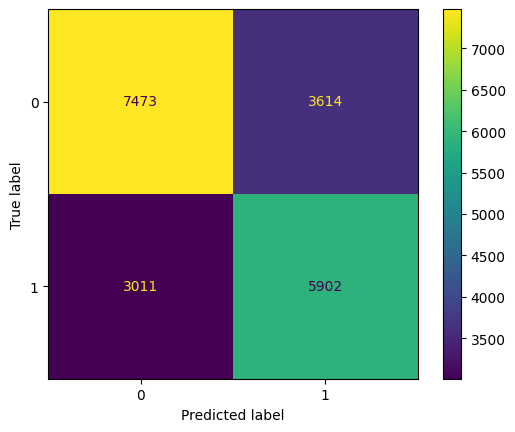

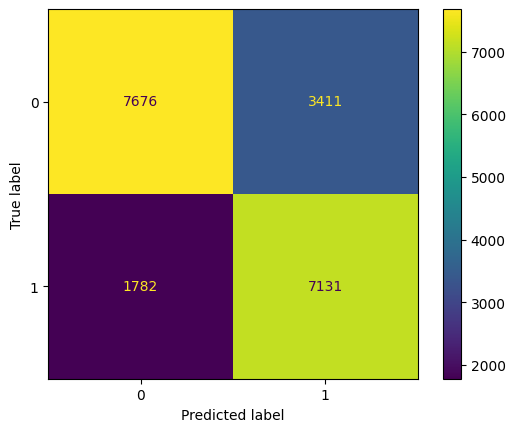

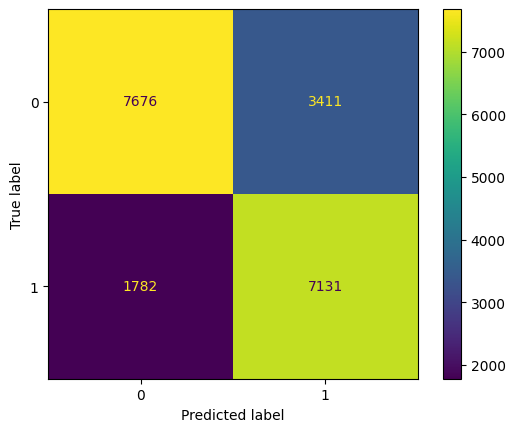

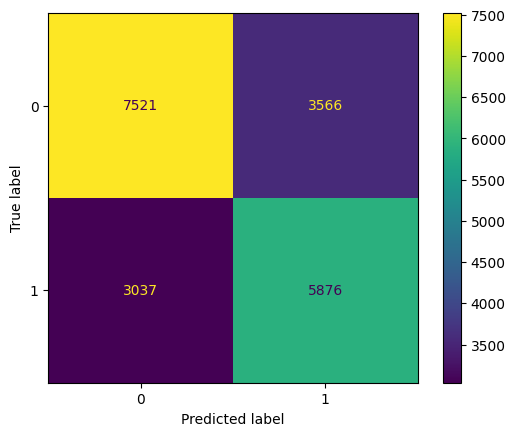

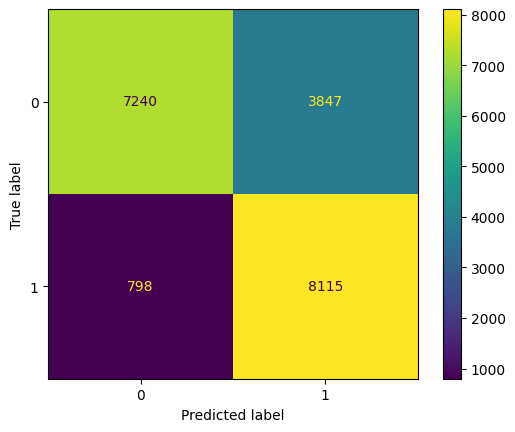

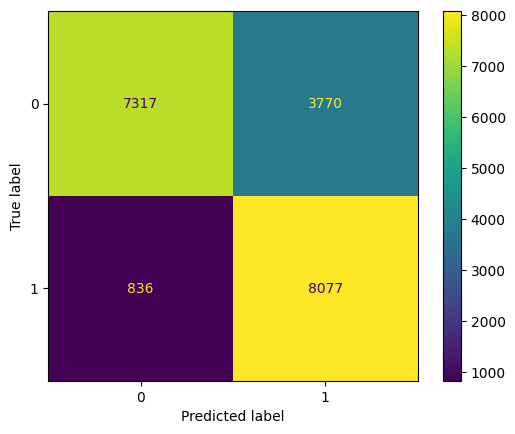

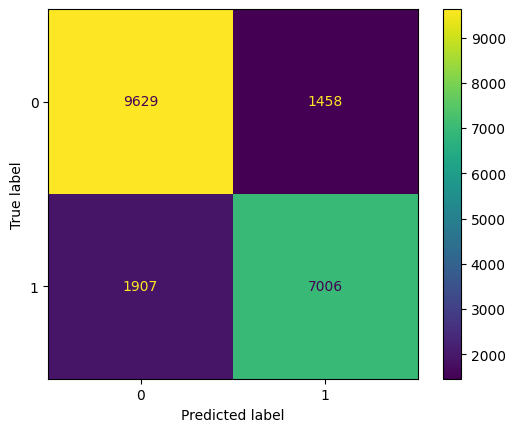

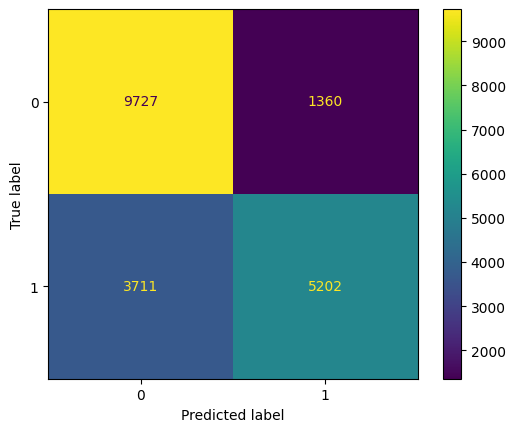

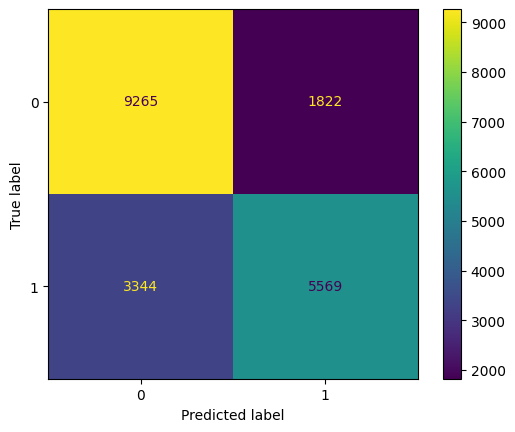

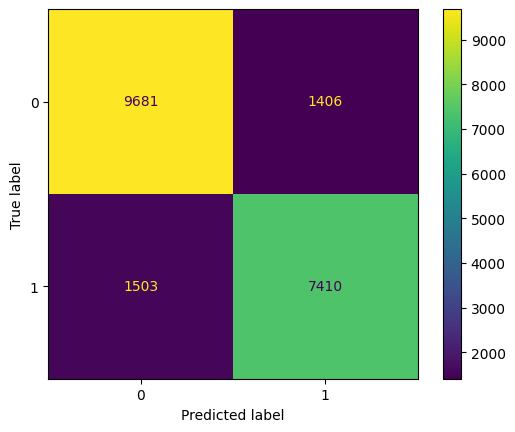

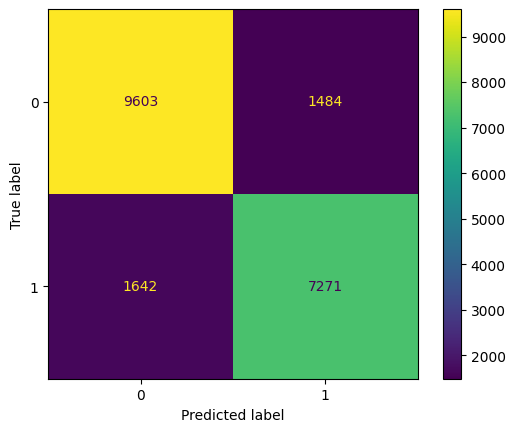

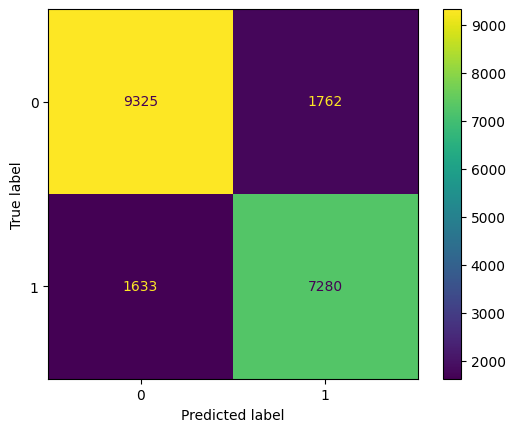

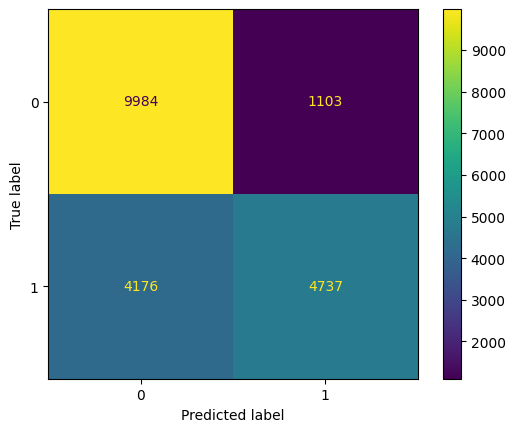

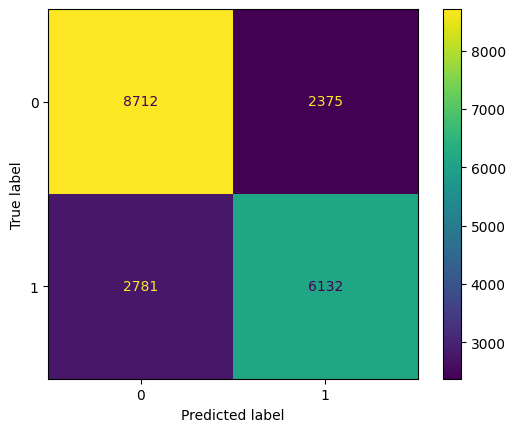

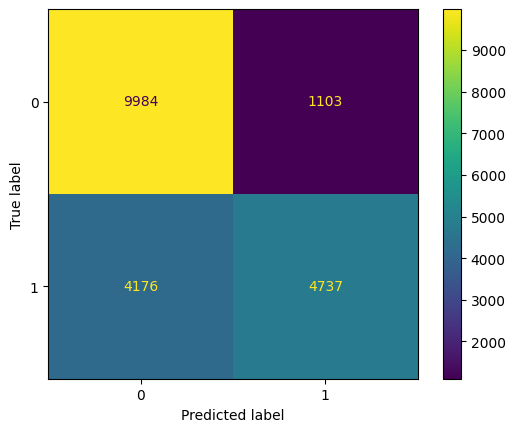

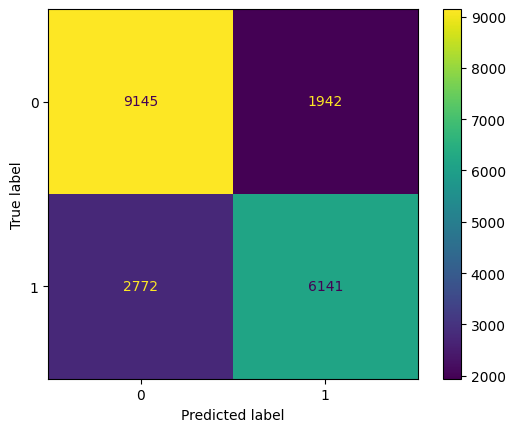

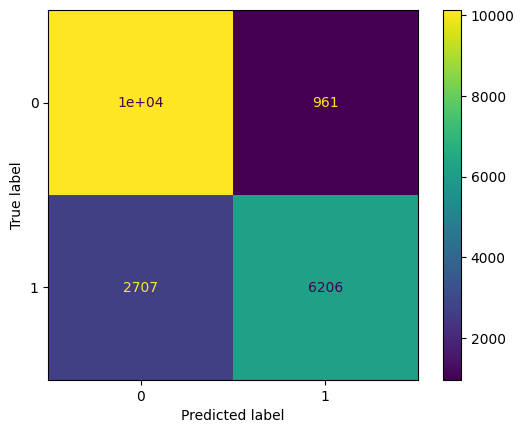

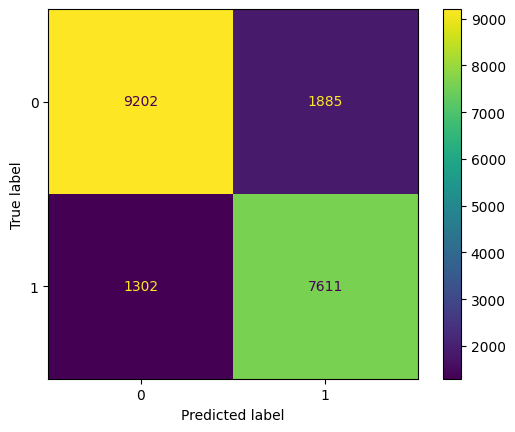

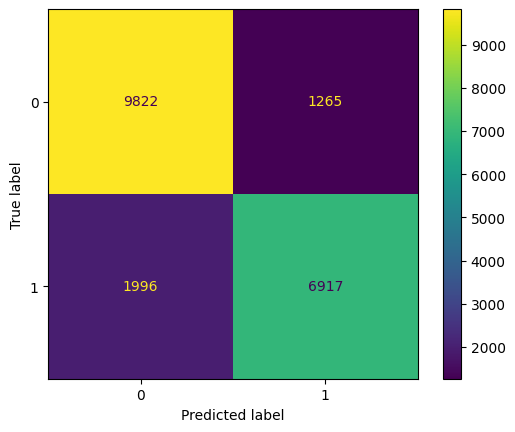

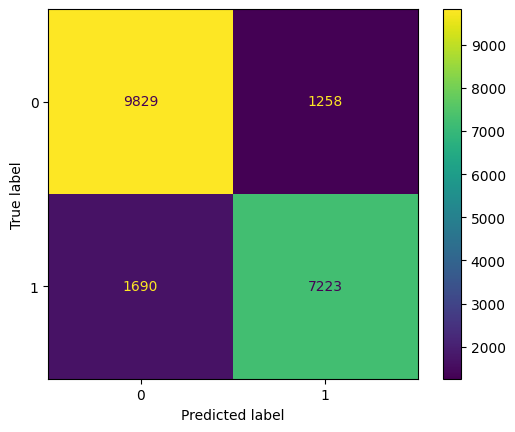

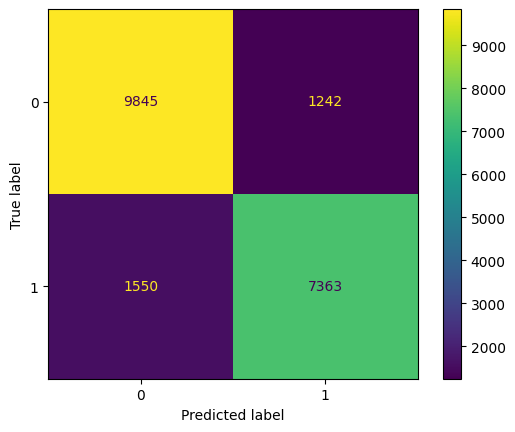

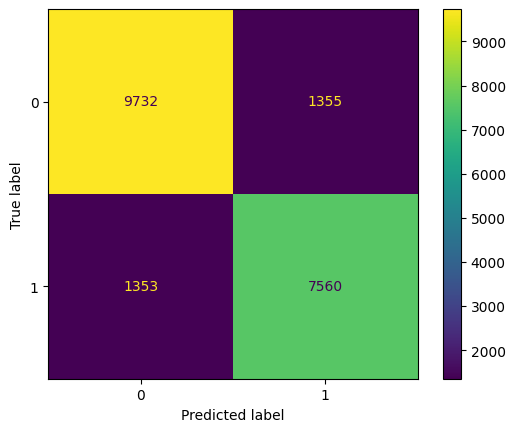

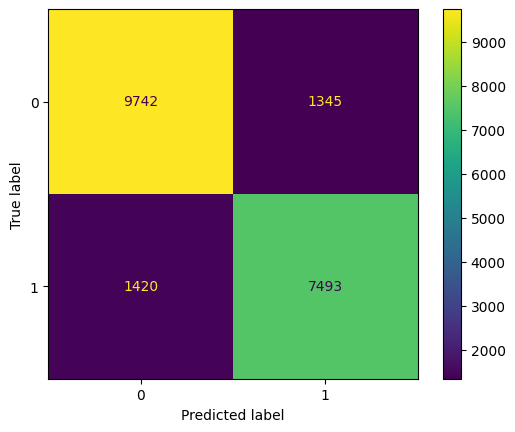

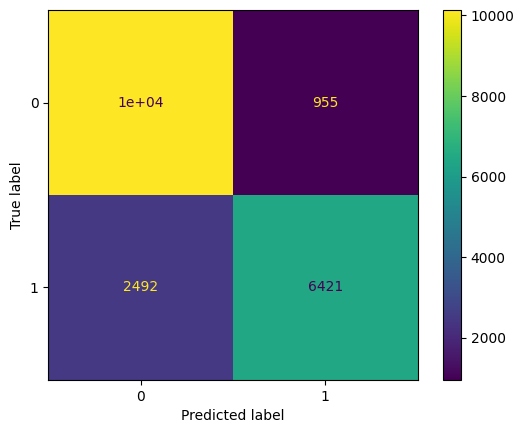

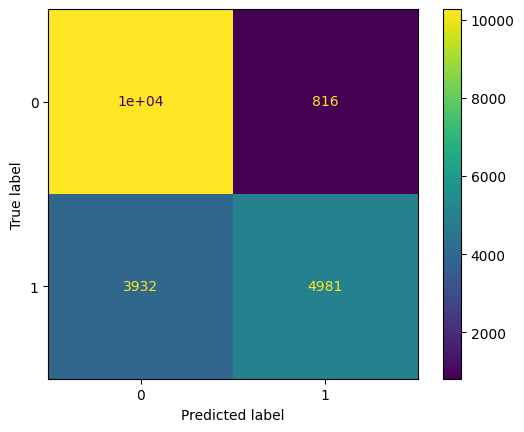

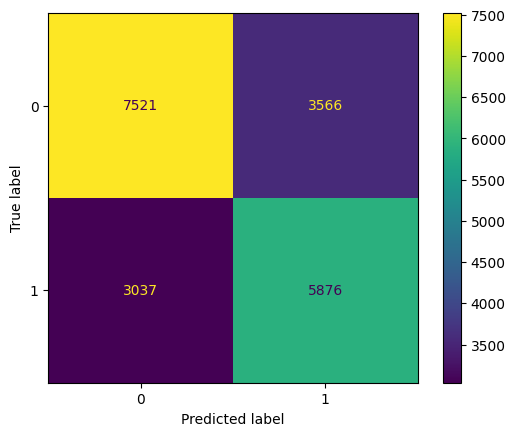

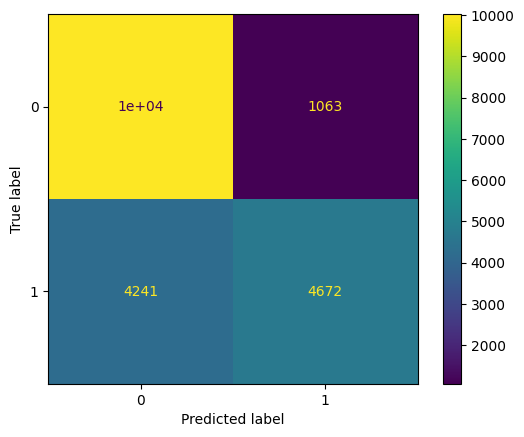

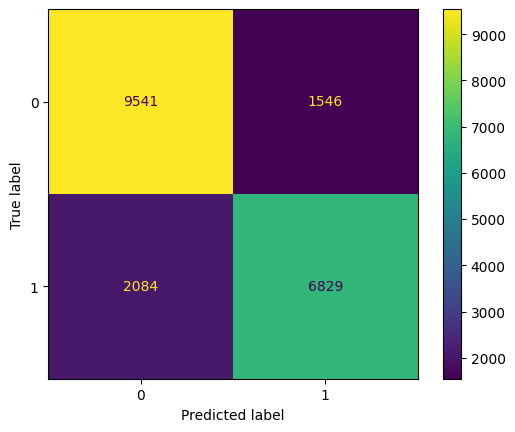

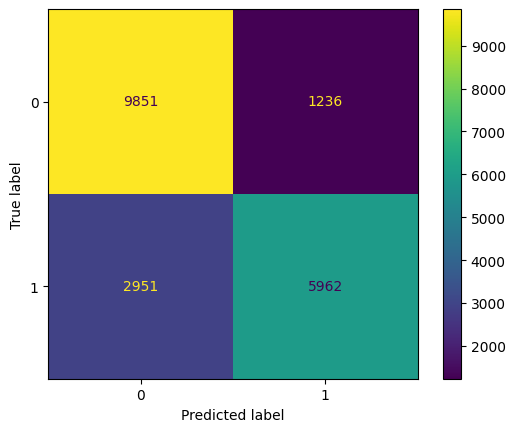

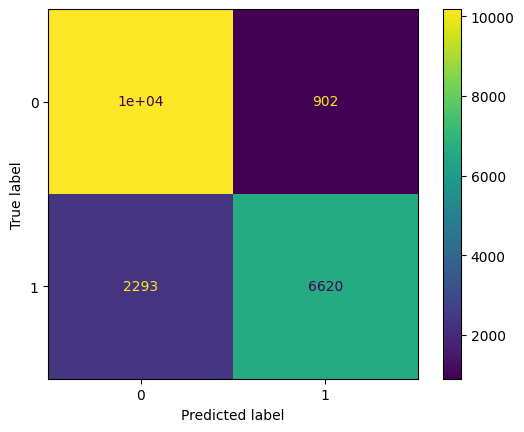

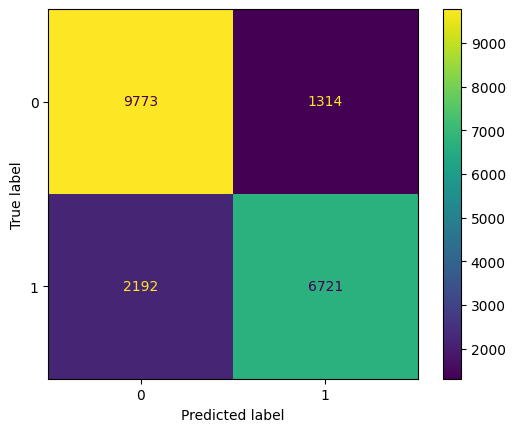

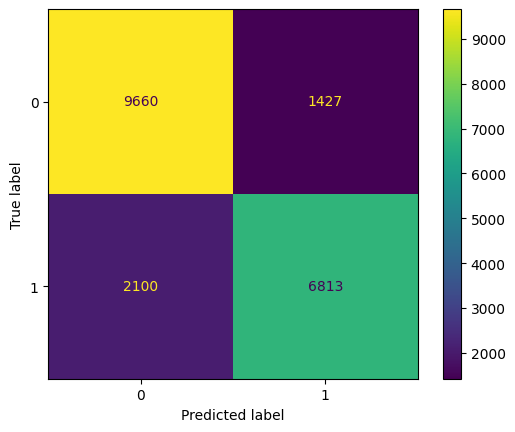

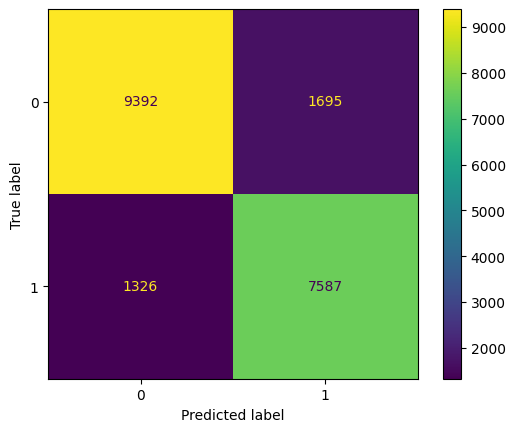

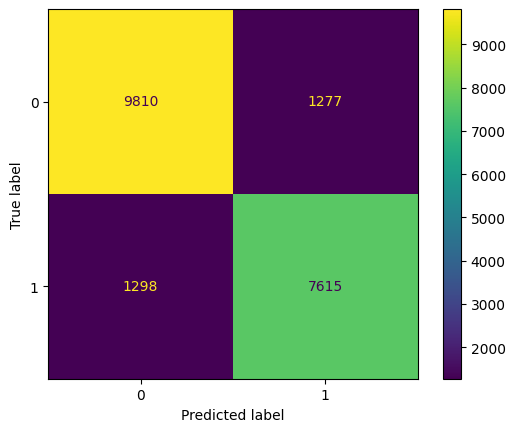

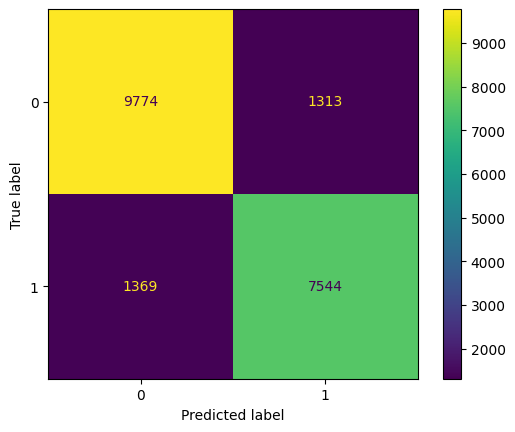

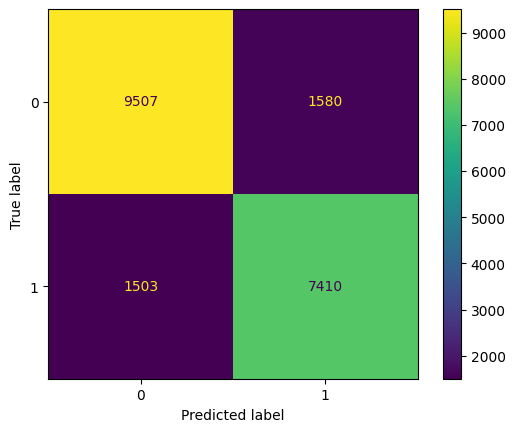

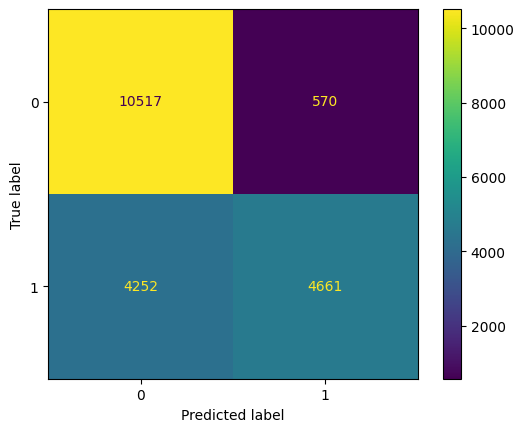

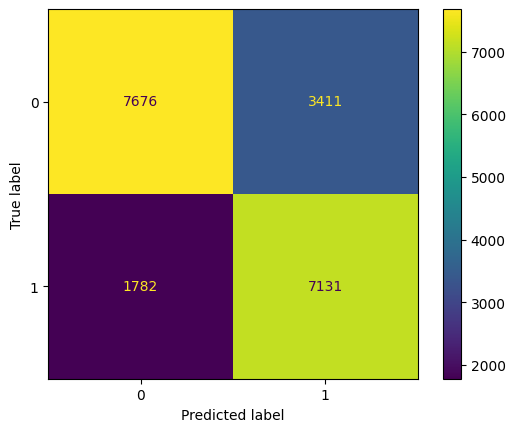

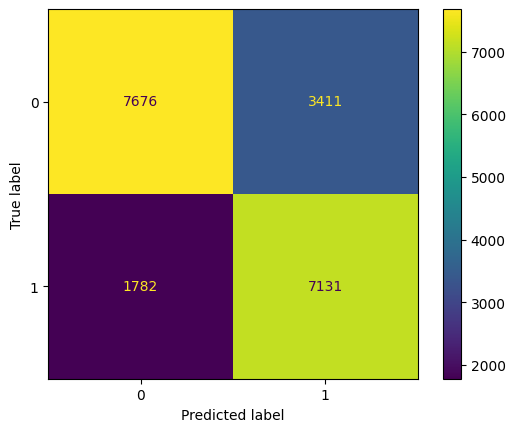

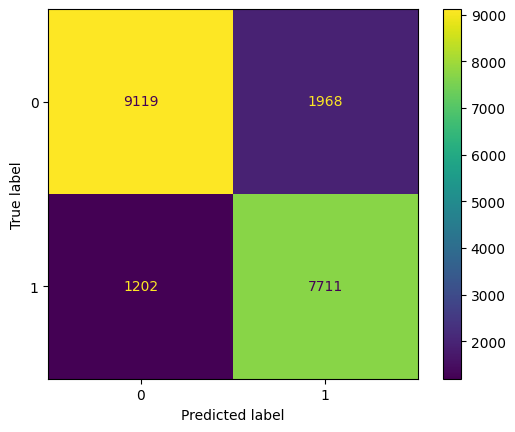

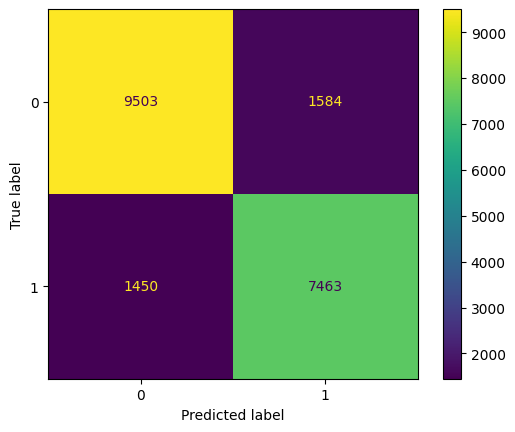

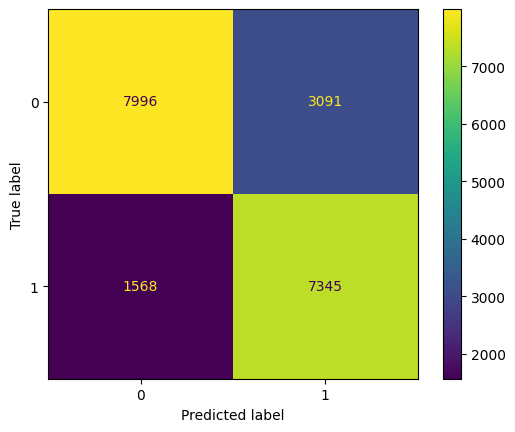

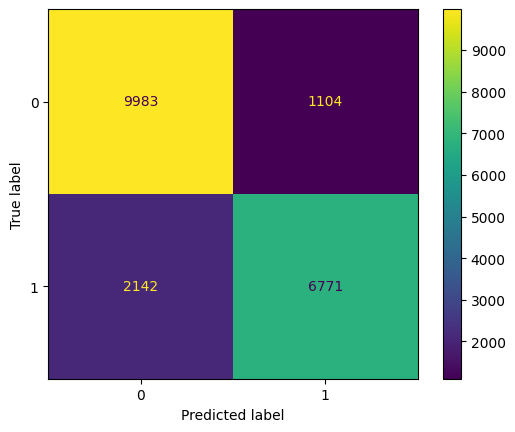

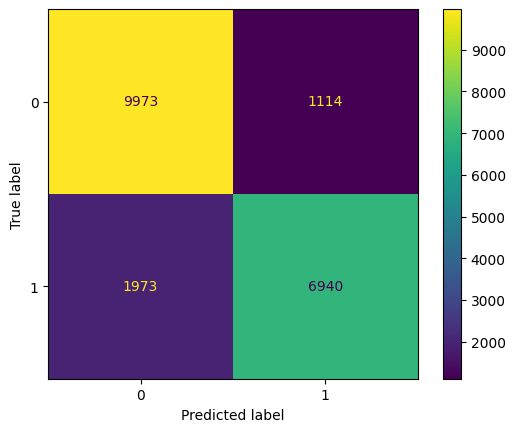

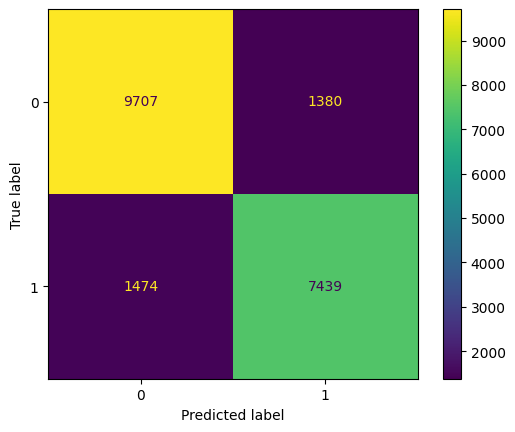

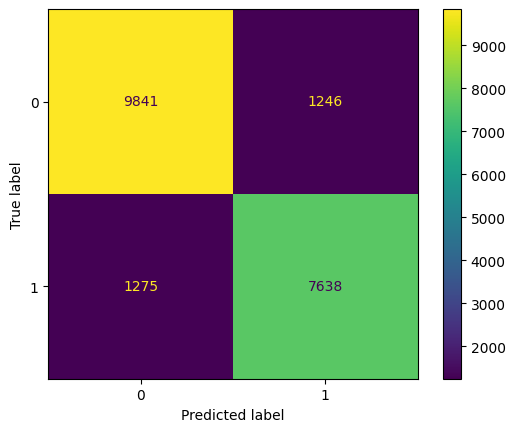

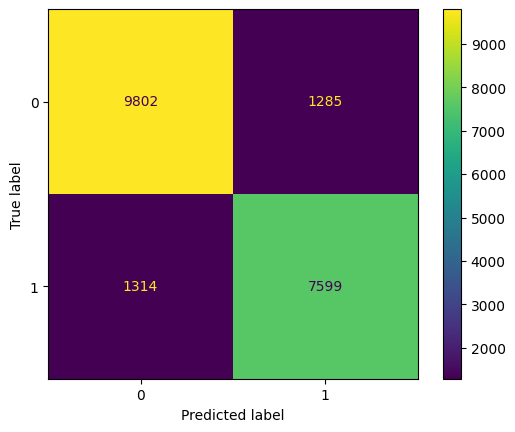

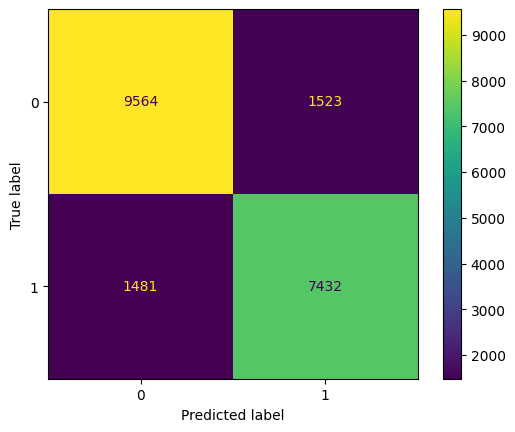

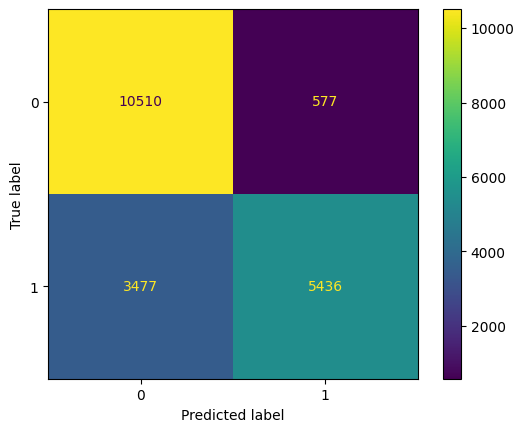

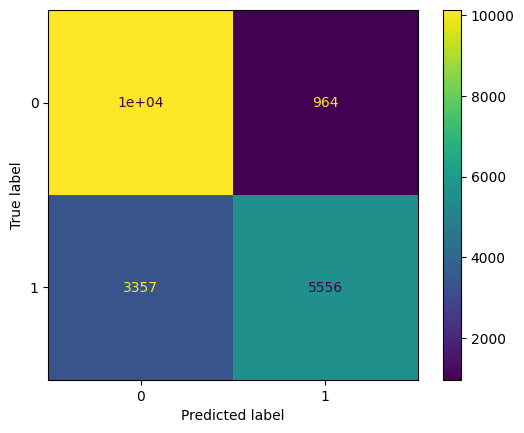

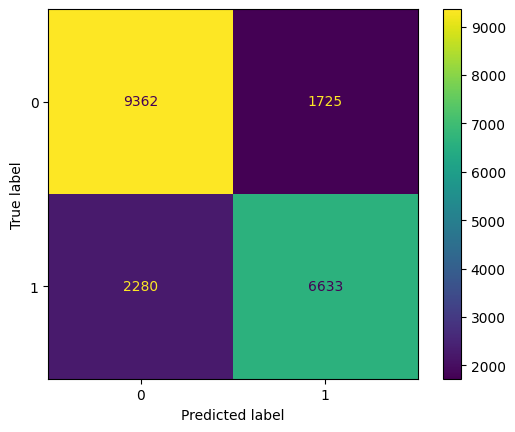

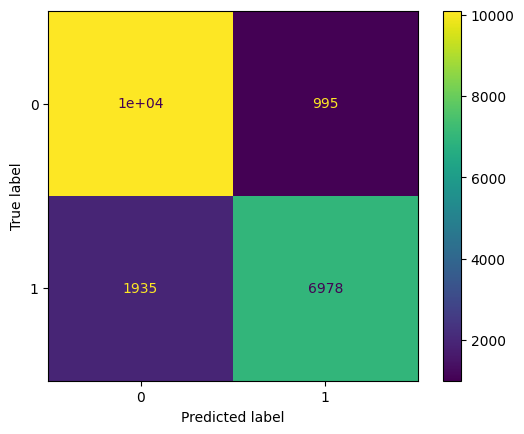

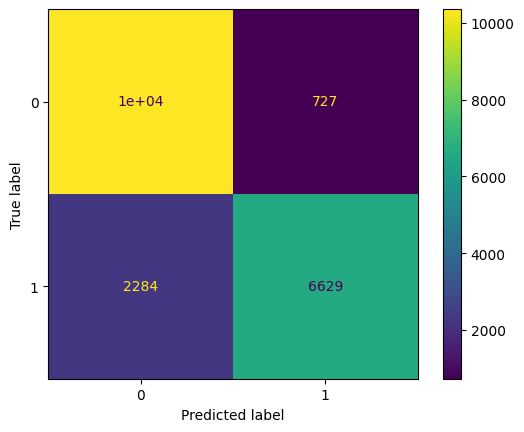

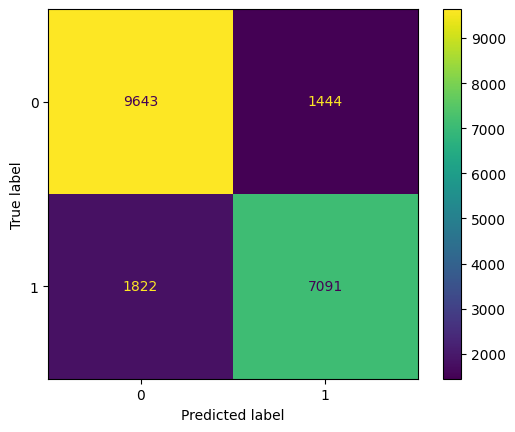

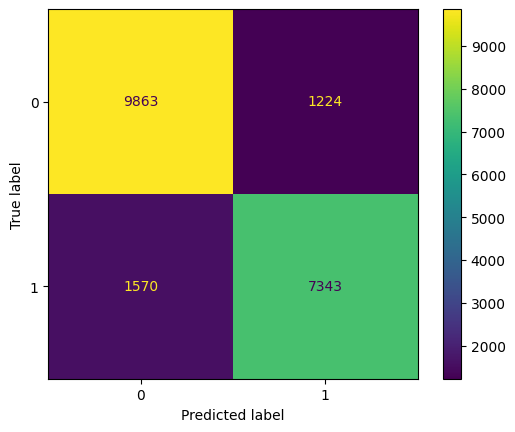

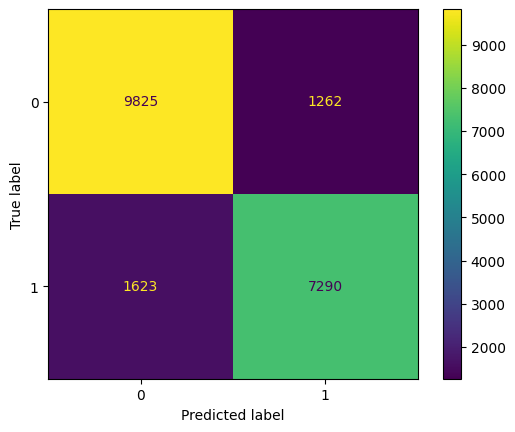

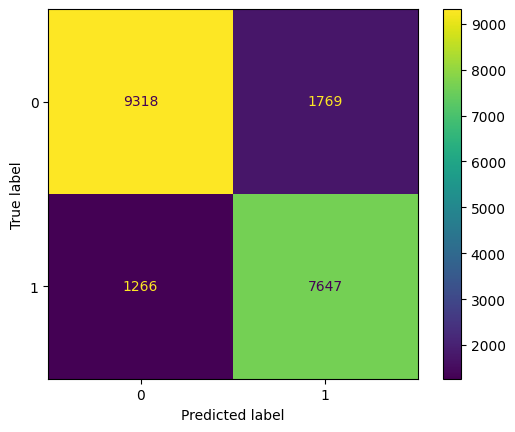

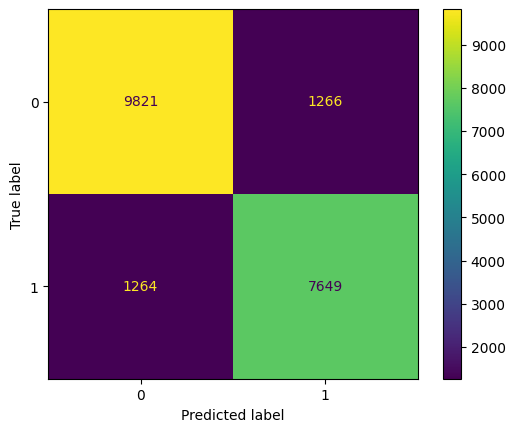

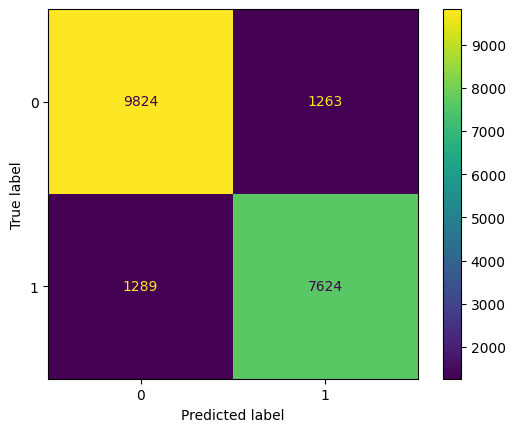

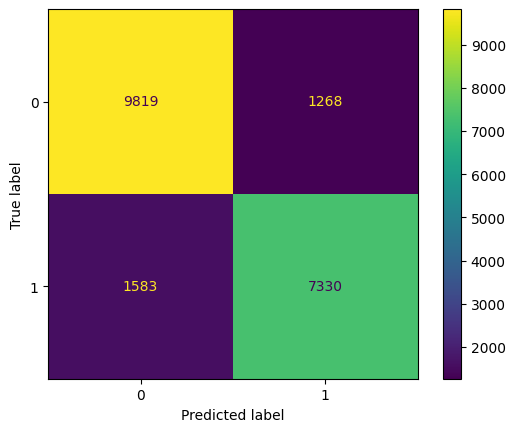

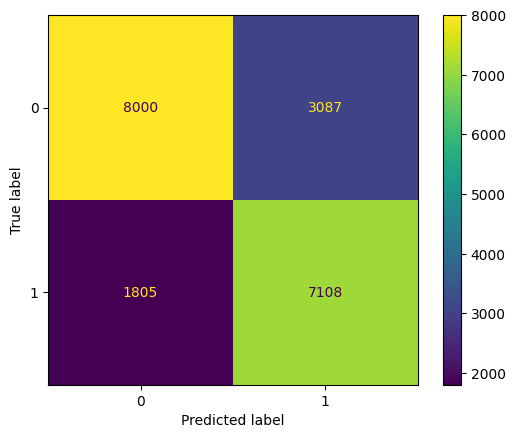

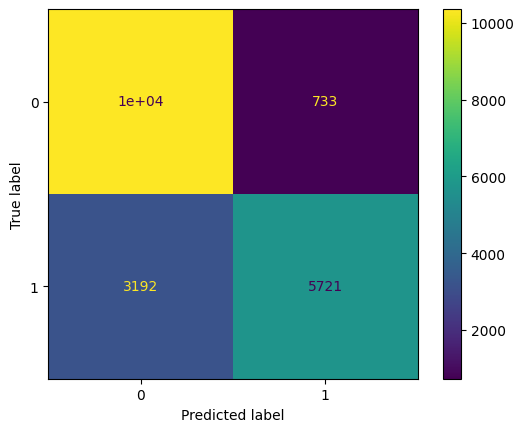

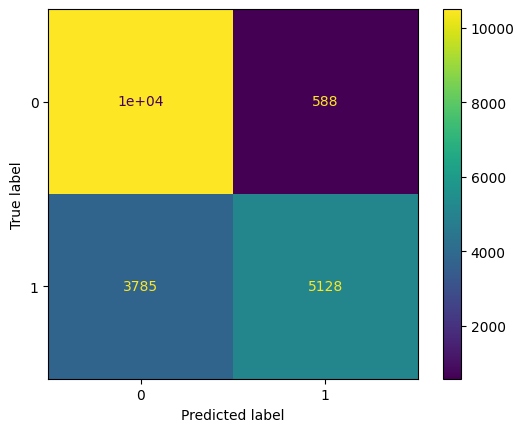

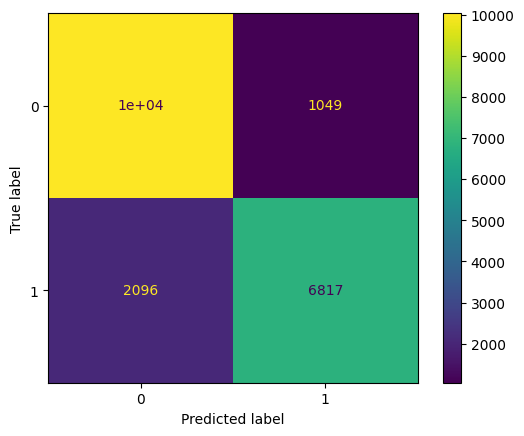

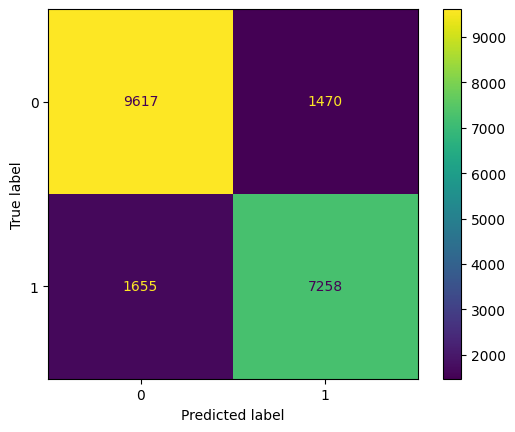

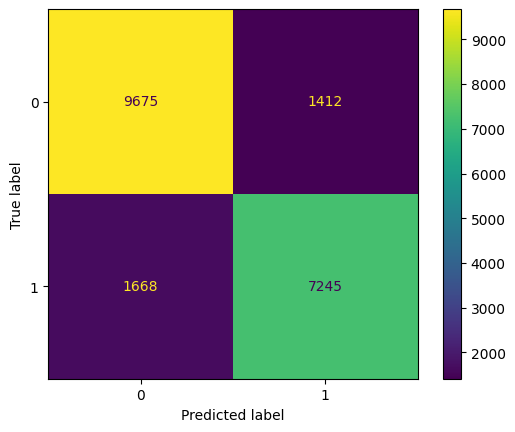

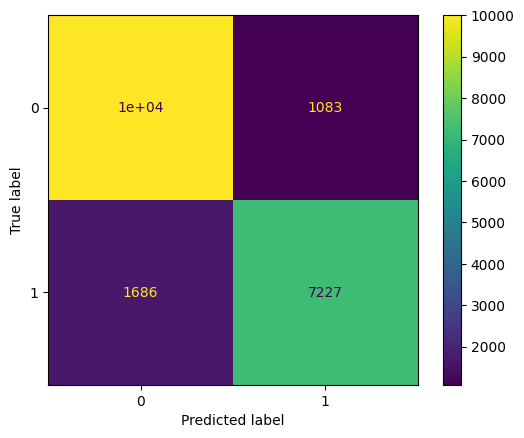

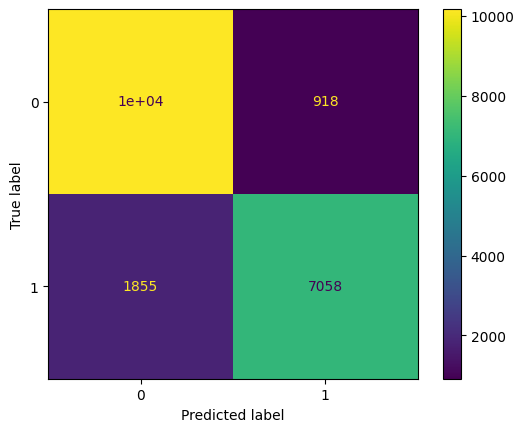

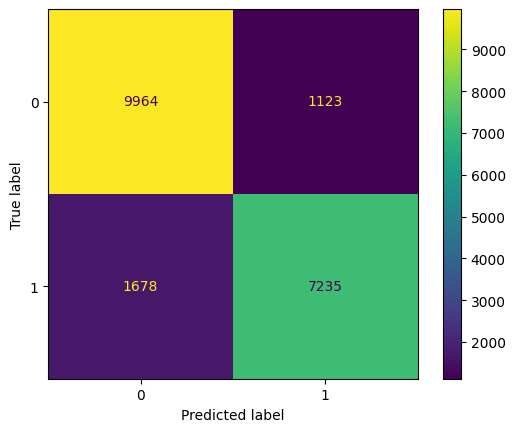

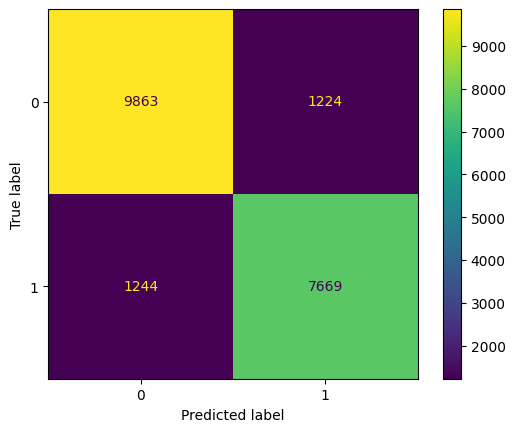

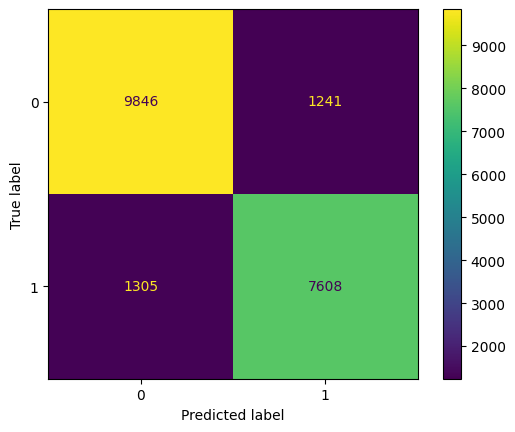

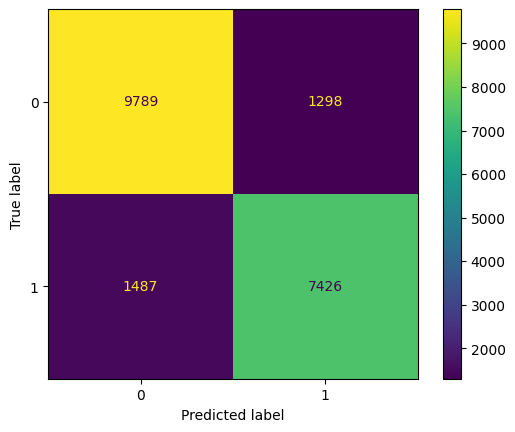

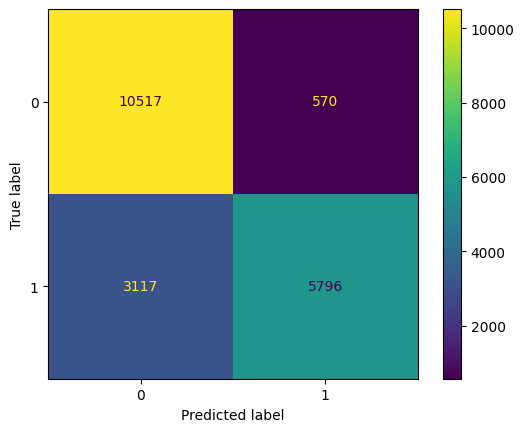

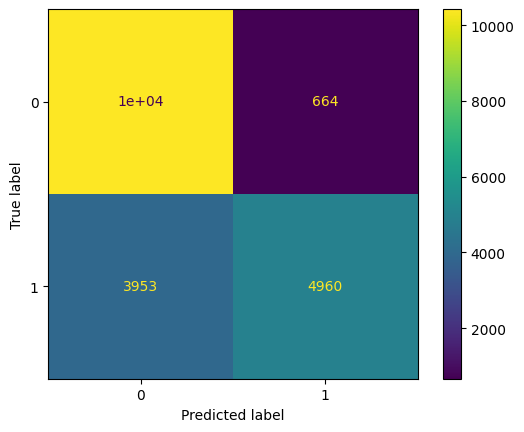

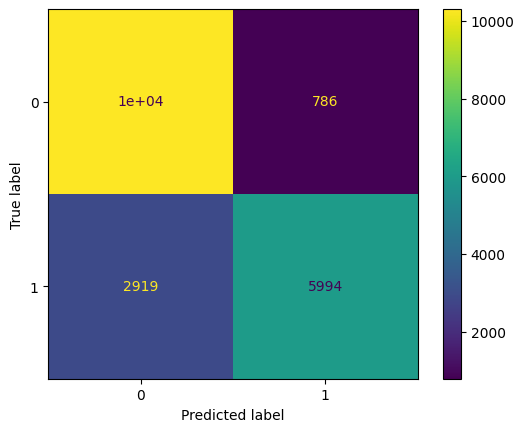

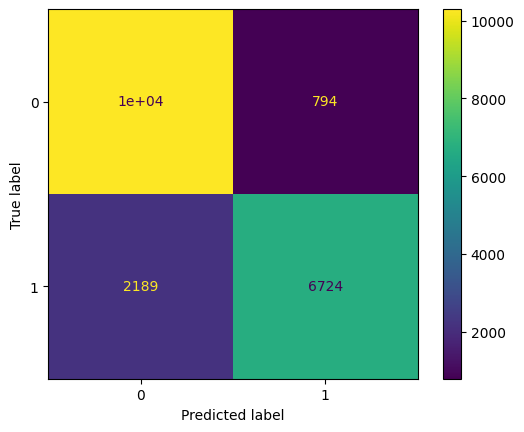

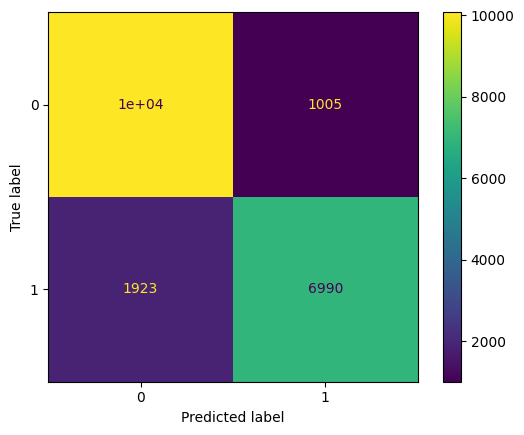

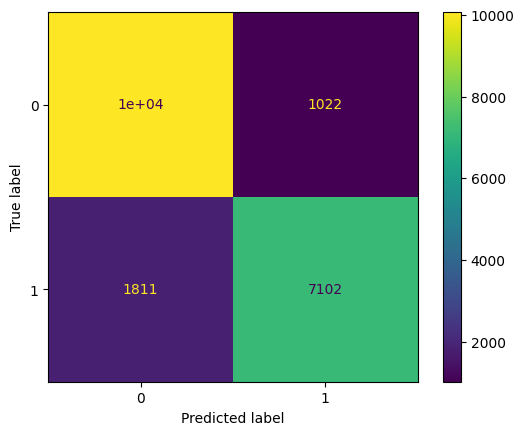

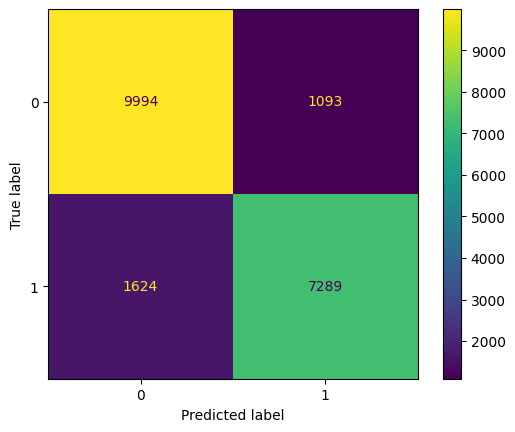

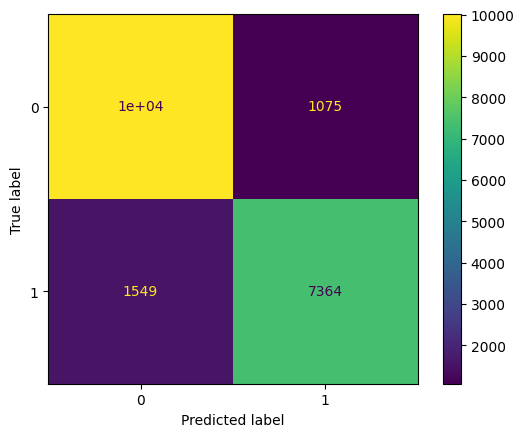

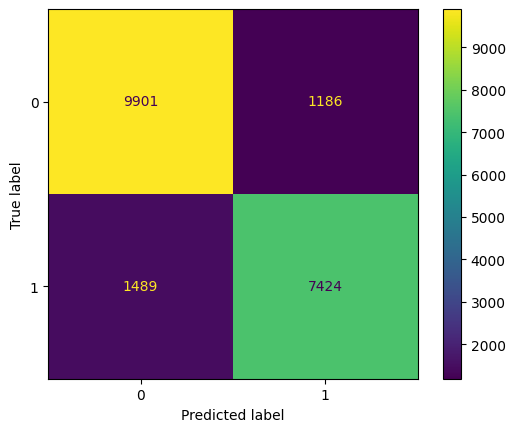

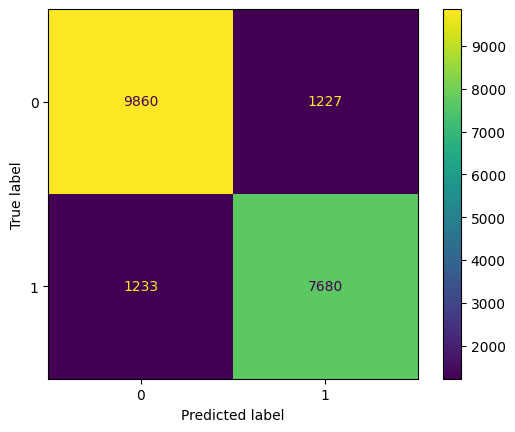

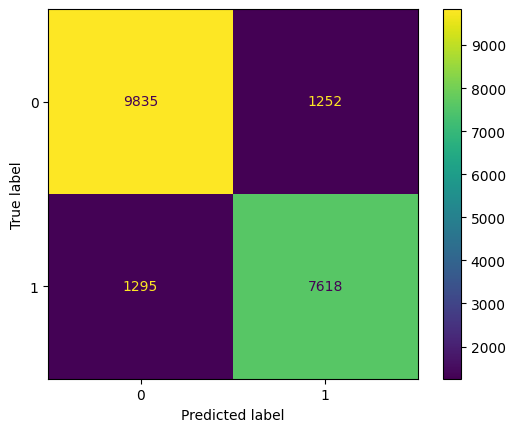

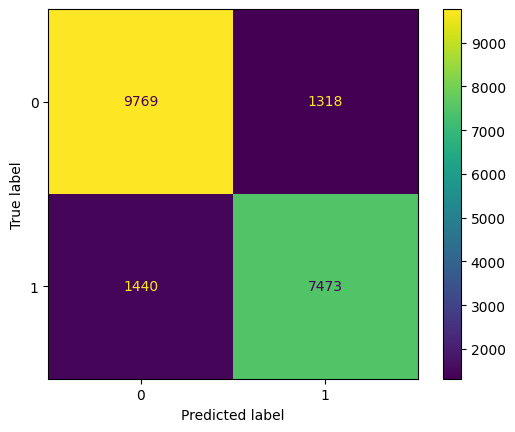

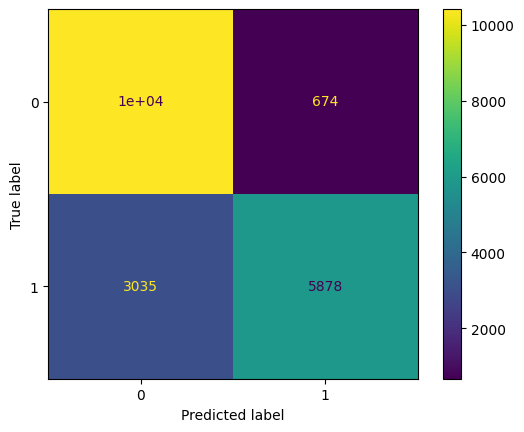

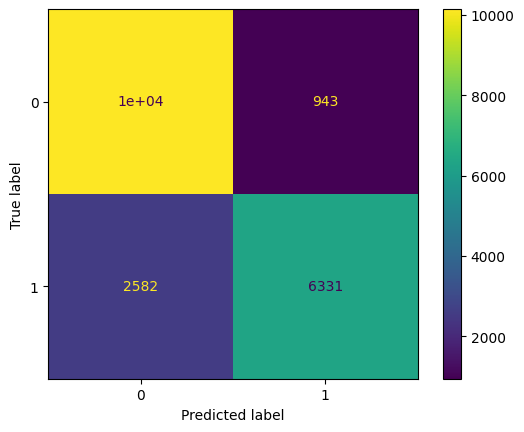

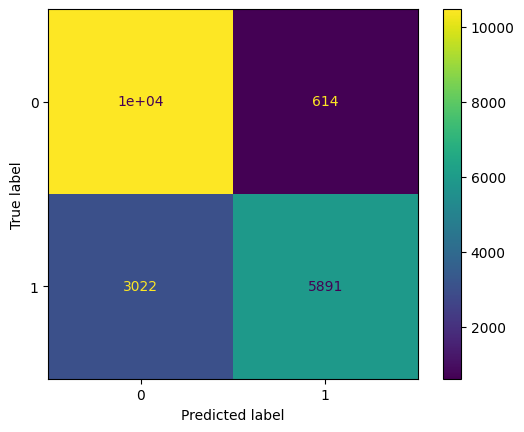

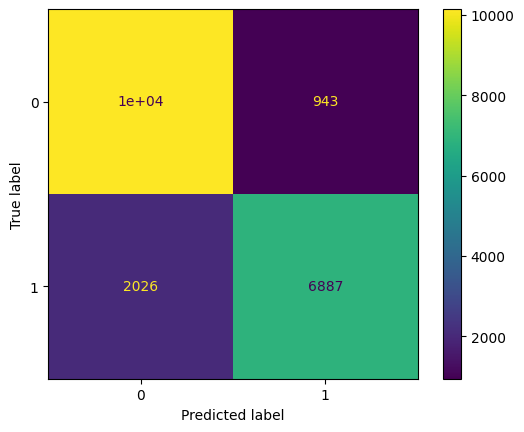

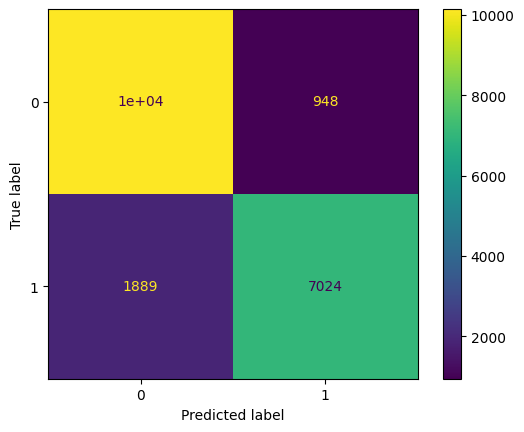

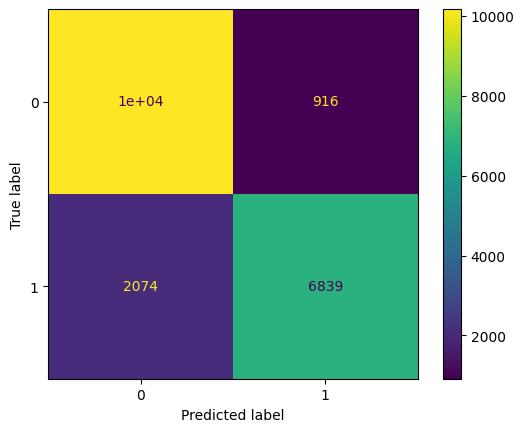

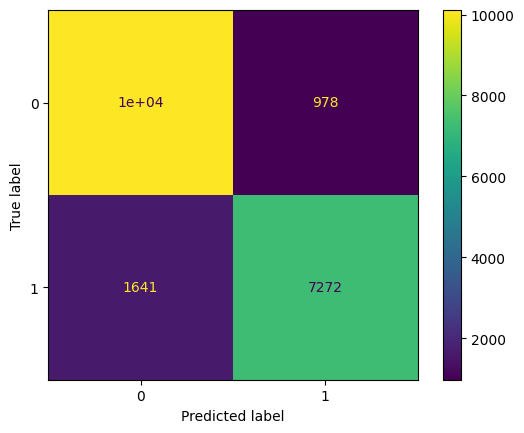

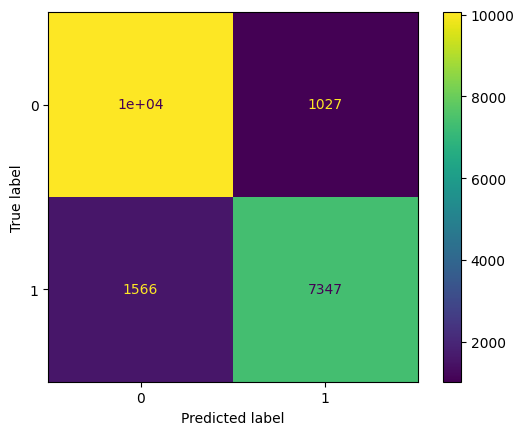

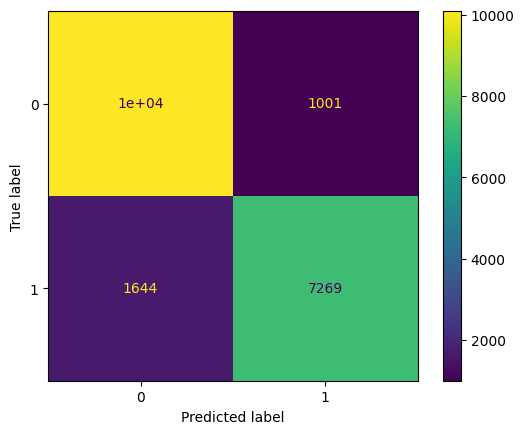

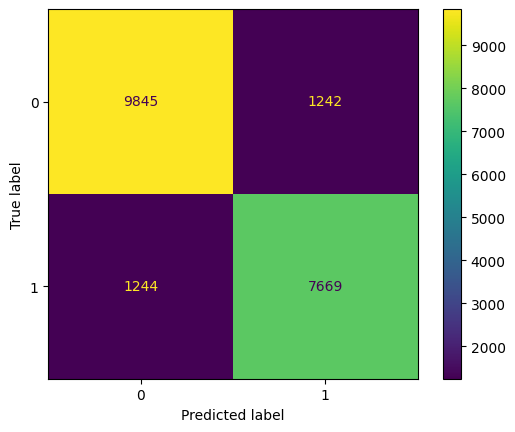

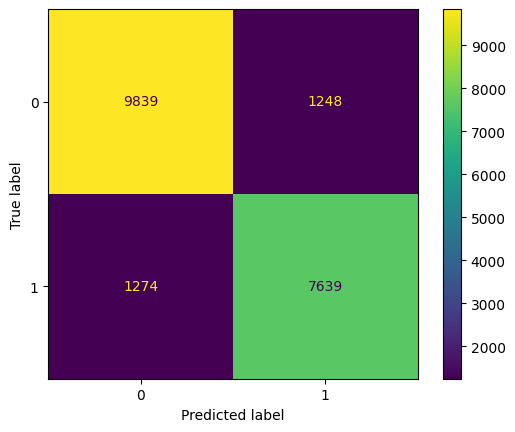

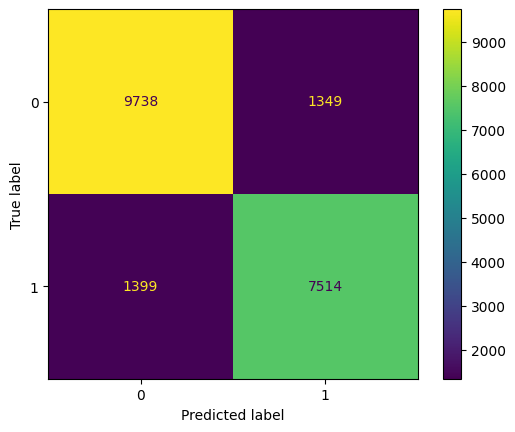

In [30]:
for a in n_estimators:
  for b in max_depth:
    for c in min_samples_leaf:

      #print(a,b,c)
      myrunid = str(uuid.uuid1())
      run = experiment.start_logging(run_id=myrunid,
                               display_name=f"My Run {myrunid} feito em aula",
                               outputs="modelo",
                               snapshot_directory="dadostreino")
      run.log("Tipo", "Classificador")

      independentcols = ['renda', 'idade', 'etnia', 'sexo', 'casapropria', 'outrasrendas', 'estadocivil', 'escolaridade']
      X = mydf[independentcols]
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
      clf = rfc(n_estimators=a, max_depth=b, min_samples_leaf=c)
      clf.fit(X=X_train[independentcols], y=y_train)
      clf.independentcols = independentcols

      clf_acuracia = clf.score(X=X_test[independentcols], y=y_test)
      print("Modelo - (classificador), criado com acurácia de: [{0}]".format(clf_acuracia))
      run.log("acuracia", clf_acuracia)

      #Demais logs (não serão comparados)
      run.log("python", sys.version)
      run.log("Versao sklearn", sklearn.__version__)
      run.log("criterion", clf.criterion)
      run.log("n_estimators", clf.n_estimators)
      run.log("min_samples_leaf", clf.min_samples_leaf)
      run.log("max_depth",  str(clf.max_depth))
      run.log_list("Inputs", independentcols)

      #Exibe Matriz de confusão e grava em arquivo
      display(f"Matriz de confusão do modelo:")
      ConfusionMatrixDisplay.from_estimator(clf, X_test[independentcols], y_test).figure_.savefig('modelo/confusion_matrix.png')

      #Exibe Classification Report e grava em arquivo
      c_report = classification_report(y_test, clf.predict(X_test[independentcols]))
      print(f"Classification Report:\n{c_report}")
      with open("modelo/classification_report.txt", "w") as text_file:
          text_file.write(c_report)

      model_name = "modelo_bin.pkl"
      filename = "modelo/" + model_name
      joblib.dump(value=clf, filename=filename)

      run.complete()
      run.wait_for_completion()
      os.remove("./modelo/modelo_bin.pkl")
      os.remove("./modelo/confusion_matrix.png")
      os.remove("./modelo/classification_report.txt")

# Atividade 2 : Regressor

Treinar um segundo modelo (Regressor sem a variavel etnia)

In [ ]:
independentcols = ['renda', 'idade', 'sexo', 'casapropria', 'outrasrendas', 'estadocivil', 'escolaridade']